This notebook analyzes trading performance with three main visualizations:
1. Benchmark comparison with TQQQ (log scale)
2. Fixed capital PnL
3. Trade duration distribution

The analysis uses two datasets:
- `full_compounding.csv`: Uses entire account value as risk capital
- `fixed_capital.csv`: Uses fixed 100k as risk capital

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.ticker import FuncFormatter
from IPython.display import display
from datetime import timedelta

sns.set_theme()

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

In [8]:
# Load data
compounding_df = pd.read_csv('../data/compounded_20vol.csv', parse_dates=['Entry time', 'Exit time'])
fixed_df = pd.read_csv('../data/fixed_capital.csv', parse_dates=['Entry time', 'Exit time'])

print(f"Total number of trades: {len(compounding_df)}")
print(f"Date range: {compounding_df['Entry time'].min().date()} to {compounding_df['Entry time'].max().date()}")

Total number of trades: 1960
Date range: 2017-01-10 to 2025-01-23


1. Benchmark Comparison with TQQQ (Log Scale)

This analysis compares the strategy's cumulative compound return against TQQQ on a log scale.

[*********************100%***********************]  1 of 1 completed


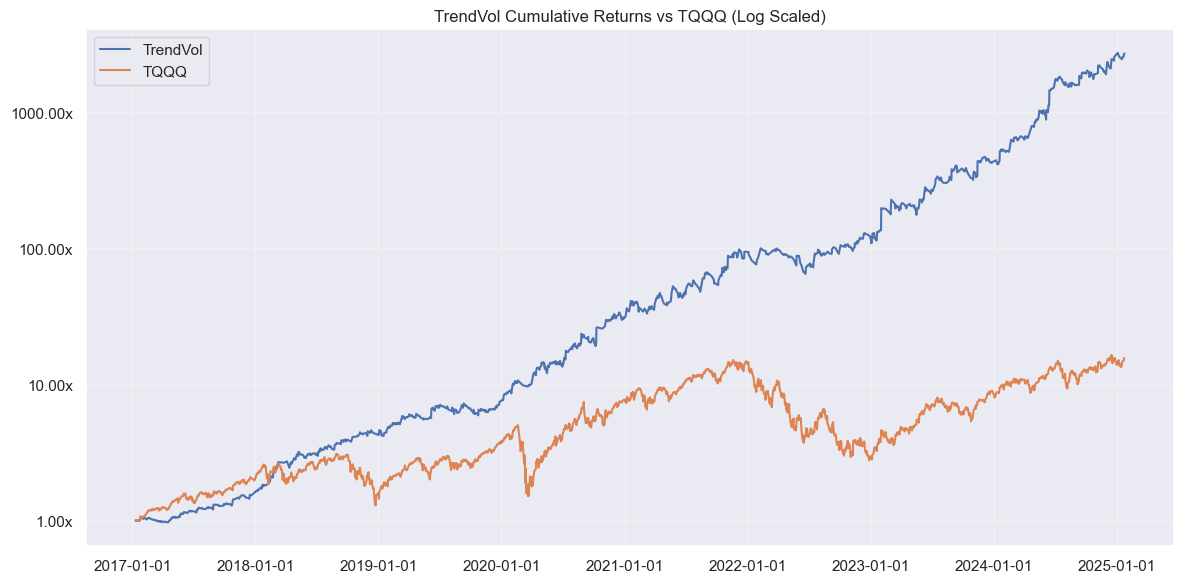

In [9]:
def plot_benchmark_comparison(df):
    # Group and aggregate daily returns
    daily = df.groupby(df['Entry time'].dt.date).agg({
        'Return': 'sum',
        'Entry time': 'last'
    }).reset_index(drop=True)
    
    # Calculate cumulative returns
    daily['Cum_Return'] = (1 + daily['Return']).cumprod()
    
    # Get date range
    start_date = daily['Entry time'].min()
    end_date = daily['Entry time'].max()
    
    # Download TQQQ data
    tqqq = yf.download('TQQQ', start=start_date, end=end_date)
    tqqq['Returns'] = tqqq['Adj Close'].pct_change()
    tqqq['Cum_Returns'] = (1 + tqqq['Returns']).cumprod()
    tqqq = tqqq.reset_index()
    
    # Create return formatter
    def return_formatter(x, p):
        return f'{x:.2f}x'
    
    # Create plot
    fig, ax = plt.subplots()
    
    # Plot both lines
    ax.plot(daily['Entry time'], daily['Cum_Return'], label='TrendVol')
    ax.plot(tqqq['Date'], tqqq['Cum_Returns'], label='TQQQ')
    
    # Set log scale
    ax.set_yscale('log')
    
    # Format axes
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.yaxis.set_major_formatter(return_formatter)
    
    plt.title('TrendVol Cumulative Returns vs TQQQ (Log Scaled)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    return fig

# Plot the benchmark comparison
fig_benchmark = plot_benchmark_comparison(compounding_df)
plt.show()

2. Performance analysis at different risk levels for last 12 months

This analysis shows the cumulative performance of the strategy over the last 12 months with different risk levels applied. Aka volatility targets.

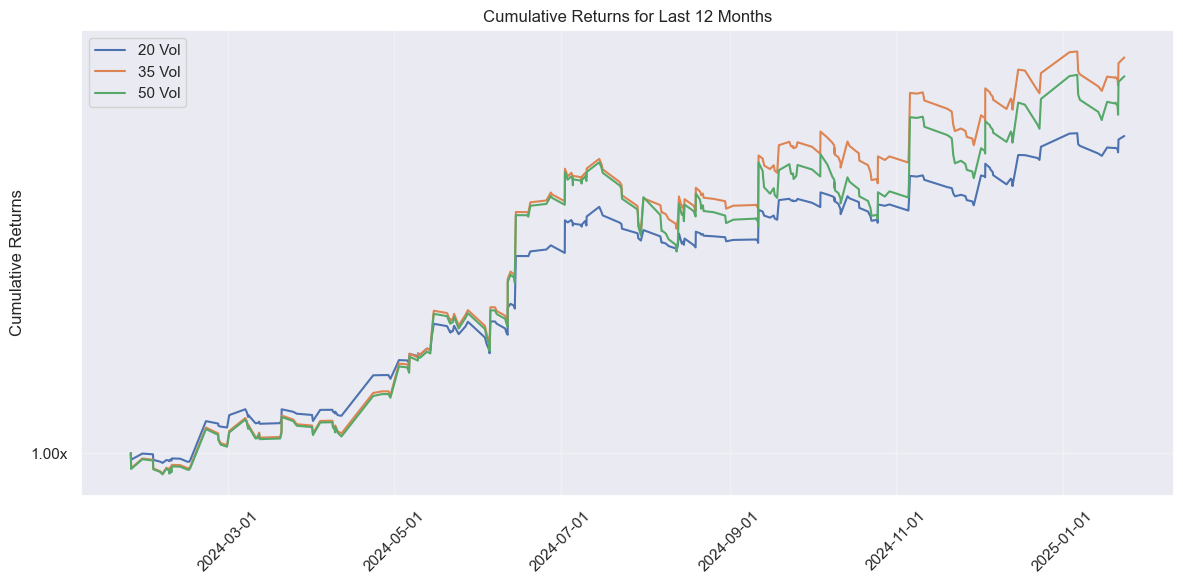

In [10]:
# Function to load data and compute cumulative returns
def load_and_process_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Entry time', 'Exit time'])
    df['Cum_Return'] = (1 + df['Return']).cumprod()
    return df

# Function to normalize cumulative returns
def normalize_cumulative_returns(df):
    df = df.copy()  # Create a copy to avoid the warning
    initial_value = df['Cum_Return'].iloc[0]
    df['Normalized_Cum_Return'] = df['Cum_Return'] / initial_value
    return df

# Load datasets
vol20_df = load_and_process_data('../data/compounded_20vol.csv')
vol35_df = load_and_process_data('../data/compounded_35vol.csv')
vol50_df = load_and_process_data('../data/compounded_50vol.csv')

# Determine the last 12 months range
end_date = vol20_df['Entry time'].max()
start_date = end_date - timedelta(days=365)

# Filter data for the last 12 months
vol20_last_12_months_df = vol20_df[vol20_df['Entry time'] >= start_date].copy()
vol35_last_12_months_df = vol35_df[vol35_df['Entry time'] >= start_date].copy()
vol50_last_12_months_df = vol50_df[vol50_df['Entry time'] >= start_date].copy()

# Normalize cumulative returns
vol20_last_12_months_df = normalize_cumulative_returns(vol20_last_12_months_df)
vol35_last_12_months_df = normalize_cumulative_returns(vol35_last_12_months_df)
vol50_last_12_months_df = normalize_cumulative_returns(vol50_last_12_months_df)

# Create the plot
fig, ax = plt.subplots()

# Plot normalized returns
ax.plot(vol20_last_12_months_df['Entry time'], vol20_last_12_months_df['Normalized_Cum_Return'], label='20 Vol')
ax.plot(vol35_last_12_months_df['Entry time'], vol35_last_12_months_df['Normalized_Cum_Return'], label='35 Vol')
ax.plot(vol50_last_12_months_df['Entry time'], vol50_last_12_months_df['Normalized_Cum_Return'], label='50 Vol')

# Set y-axis to log scale
ax.set_yscale('log')

# Y-axis formatter function
def y_axis_formatter(x, _):
    return f"{x:.2f}x"

# Set y-axis formatter
ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

# Format axes
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(AutoDateLocator())
ax.set_title('Cumulative Returns for Last 12 Months')
ax.set_ylabel('Cumulative Returns')
ax.legend()

plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

3. Fixed Capital PnL Analysis

This analysis shows the P&L of the strategy on a fixed risk capital of $100,000.

Net Profit: $889,735.28
Total Commission: $34,267.44


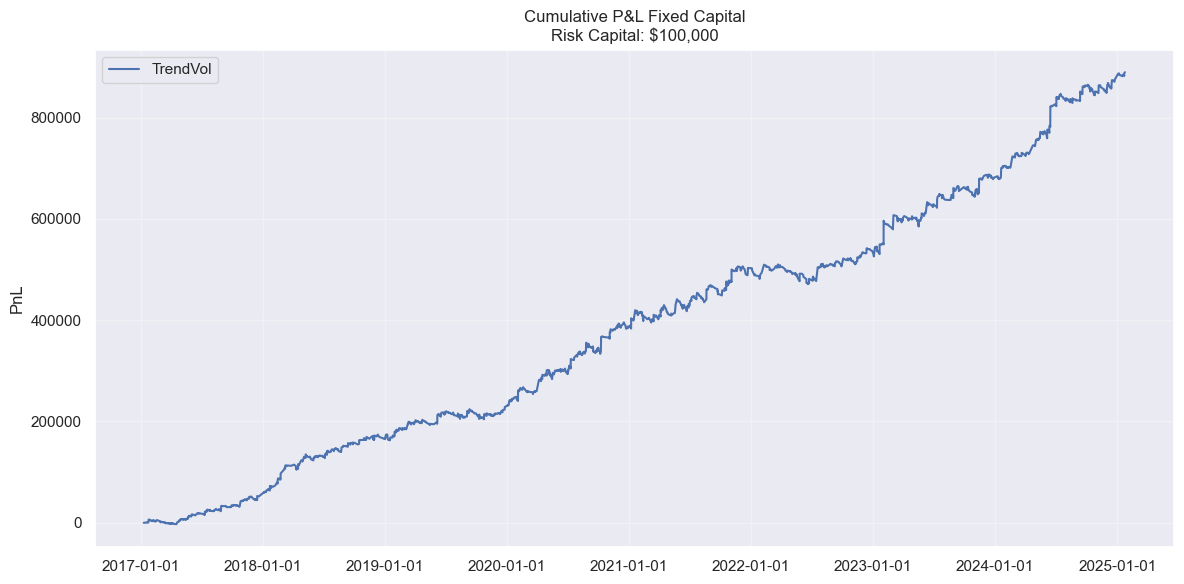

In [11]:
def plot_fixed_capital_pnl(df):
    fig, ax = plt.subplots()
    
    # Plot cumulative P&L
    ax.plot(df['Entry time'], df['Cum. net profit'], label='TrendVol')
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(AutoDateLocator())
    
    plt.title(f'Cumulative P&L Fixed Capital\nRisk Capital: $100,000')
    plt.ylabel('PnL')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    print(f"Net Profit: ${df['Cum. net profit'].iloc[-1] - df['Cum. net profit'].iloc[0]:,.2f}")
    print(f"Total Commission: ${df['Commission'].sum():,.2f}")
    
    return fig

# Plot the fixed capital PnL
fig_pnl = plot_fixed_capital_pnl(fixed_df)
plt.show()

3. Trade Duration Analysis

This analysis examines the distribution of trade holding periods.

Duration Statistics (in minutes):
Mean hold time: 574.04


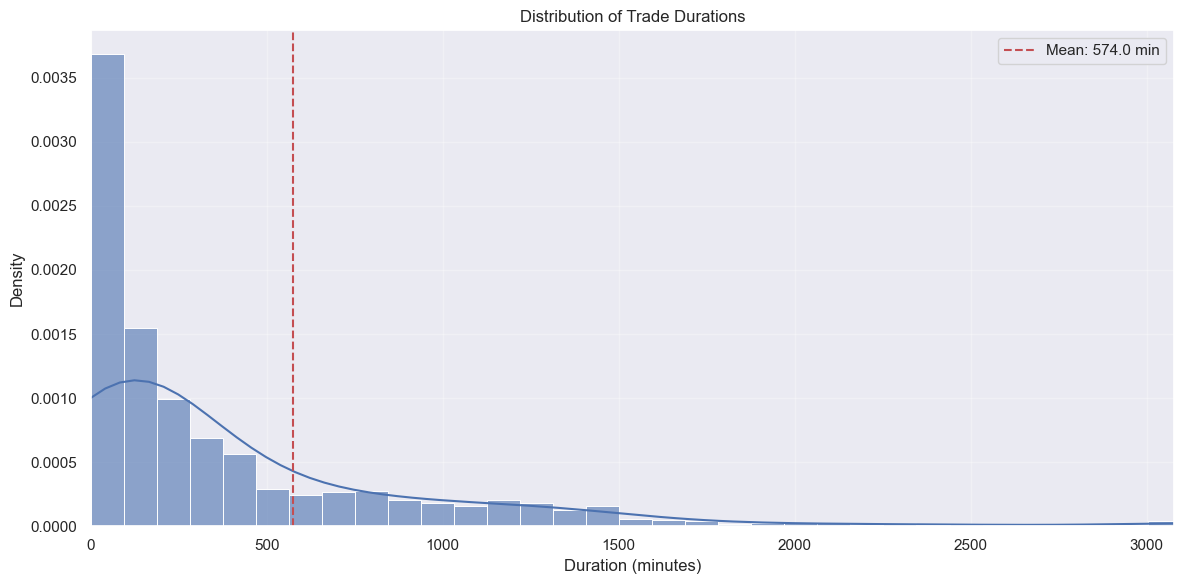

In [12]:
def plot_trade_duration(df):
    durations = (df['Exit time'] - df['Entry time']).dt.total_seconds() / 60
    mean_duration = durations.mean()
    
    fig, ax = plt.subplots()
    
    sns.histplot(durations, kde=True, alpha=0.6, stat='density')
    plt.xlim(0, durations.quantile(0.95))
    
    plt.axvline(mean_duration, color='r', linestyle='--', 
                label=f'Mean: {mean_duration:.1f} min')
    
    plt.title('Distribution of Trade Durations')
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    print(f"Duration Statistics (in minutes):")
    print(f"Mean hold time: {mean_duration:.2f}")
    return fig

# Plot the trade duration distribution
fig_duration = plot_trade_duration(compounding_df)
plt.show()